In [1]:
import pandas as pd
import quandl as qd
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression


df =qd.get("WIKI/GOOGL")

print(df.head())

C:\Users\nicol\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

Como pode ser visto o stock market apresenta 12 features. Nesse ponto é imteressante se perguntar se todas elas são necessárias para a previsão, para checar isso é possível fazer alguns teste como são demonstrado abaixo


In [2]:
df = df[["Adj. Open","Adj. High","Adj. Low","Adj. Close","Adj. Volume"]]
df["Hl_porcent"] = (df["Adj. High"]- df["Adj. Close"])/df["Adj. Close"]*100
df["porcent_change"] = (df["Adj. Close"]- df["Adj. Open"])/df["Adj. Open"]*100
df = df[["Adj. Close","Hl_porcent","porcent_change","Adj. Volume"]]

print(df.head())

            Adj. Close  Hl_porcent  porcent_change  Adj. Volume
Date                                                           
2004-08-19   50.322842    3.712563        0.324968   44659000.0
2004-08-20   54.322689    0.710922        7.227007   22834300.0
2004-08-23   54.869377    3.729433       -1.227880   18256100.0
2004-08-24   52.597363    6.417469       -5.726357   15247300.0
2004-08-25   53.164113    1.886792        1.183658    9188600.0


In [3]:
forecast_col = "Adj. Close" #Label para o valor do preço
df.fillna(-99999, inplace = True) 
#not avaiable,pandas não trabalham com valores que não são números, então é interessante subistituir por um outlier
#para não perder uma coluna

forecast_out = int(math.ceil(0.001*len(df)))
#math arredonda o valor, mas retorna como float. O interior do ceil é o número de dias que iremos prever

df["label"] = df[forecast_col].shift(-forecast_out)
#permite mudar o nome da label, enquanto shift vai mover para cima o número de colunas para, assim cada linha será o valor de adj close
df.dropna(inplace = True)
print(df.tail())

            Adj. Close  Hl_porcent  porcent_change  Adj. Volume    label
Date                                                                    
2018-03-15     1150.61    1.033365        0.090469    1623868.0  1094.00
2018-03-16     1134.42    1.973696       -1.811572    2654602.0  1053.15
2018-03-19     1100.07    1.754434       -1.582630    3076349.0  1026.55
2018-03-20     1095.80    0.889761       -0.236708    2709310.0  1054.09
2018-03-21     1094.00    1.343693        0.130884    1990515.0  1006.94


In [4]:
X = np.array(df.drop(['label'],1))#retorna o df

X = preprocessing.scale(X)#Lembrar de escalonar os valores

X_lately = X[-forecast_out:]



y = np.array(df["label"])
df.dropna(inplace=True)


X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.2)


In [10]:
clf = LinearRegression(n_jobs=-1)#n_jobs é o número de treads que podem ser rodadas paralelamente(-1 excolhe pro n° maximo que a sua cpu consegue)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Estamos medindo:",forecast_out,"dias de antecedência com", accuracy,"de acurácia")

Estamos medindo: 4 dias de antecedência com 0.9959977624220345 de acurácia


In [12]:
#Realizando predições
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[1136.80437168 1102.28866073 1097.7460761  1096.44470668] 0.9959977624220345 4


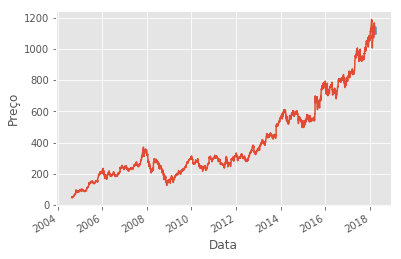

In [18]:
import math, datetime
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

df["Forecast"] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]# add os valores novos na lista

df["Adj. Close"].plot()
df['Forecast'].plot()
plt.xlabel('Data')
plt.ylabel("Preço")
plt.show()

Utilizando outro algoritmo

In [7]:
clf_svm = svm.SVR()
clf_svm.fit(X_train, y_train)
accuracy = clf_svm.score(X_test, y_test)
print("Estamos medindo:",forecast_out,"dias de antecedência com", accuracy,"de acurácia")

Estamos medindo: 4 dias de antecedência com 0.8144425999723354 de acurácia


In [8]:
clf_svm = svm.SVR(kernel = "poly")
clf_svm.fit(X_train, y_train)
accuracy = clf_svm.score(X_test, y_test)
print("Estamos medindo:",forecast_out,"dias de antecedência com", accuracy,"de acurácia")

Estamos medindo: 4 dias de antecedência com 0.5504501207009354 de acurácia
